In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Tue Jan 16 18:14:10 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   30C    P0    43W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.normal_prior import Prior
from model.latent.lse_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]
hp.M = 1024
hp.N = 256

In [5]:
''' Find Optimum Log-Sigma'''
from util.loglikelihood import get_optimum_log_sigma

p_samples1 = torch.randn(hp.M, hp.z_dim).cuda()
p_samples2 = torch.randn(hp.N, hp.z_dim).cuda()
log_sigmas = np.array([get_optimum_log_sigma(p_samples1, p_samples2) for _ in range(100)])
optimum_log_sigma = np.median(log_sigmas)
print(optimum_log_sigma)

hp.init_log_sigma = optimum_log_sigma

-0.6969696969696968


In [6]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(10):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
prior 0.0
latent 3.814697265625e-06
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [7]:
save_dir = '/data/scpark/save/lse/train01.16-2/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 371216
-rw-rw-r-- 1 scpark scpark    293616  1월 16 18:14 events.out.tfevents.1705395228.GPUSVR11
-rw-rw-r-- 1 scpark scpark 379791051  1월 16 17:53 save_0
-rw-rw-r-- 1 scpark scpark        40  1월 16 17:53 events.out.tfevents.1705395204.GPUSVR11
-rw-rw-r-- 1 scpark scpark        40  1월 16 17:53 events.out.tfevents.1705395145.GPUSVR11
-rw-rw-r-- 1 scpark scpark        40  1월 16 17:52 events.out.tfevents.1705395040.GPUSVR11
-rw-rw-r-- 1 scpark scpark        40  1월 16 17:50 events.out.tfevents.1705395007.GPUSVR11
-rw-rw-r-- 1 scpark scpark        40  1월 16 17:49 events.out.tfevents.1705394957.GPUSVR11
-rw-rw-r-- 1 scpark scpark        40  1월 16 17:48 events.out.tfevents.1705394900.GPUSVR11
-rw-rw-r-- 1 scpark scpark        40  1월 16 17:48 events.out.tfevents.1705394820.GPUSVR11


### Dataset

In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=hp.N, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [9]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [10]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


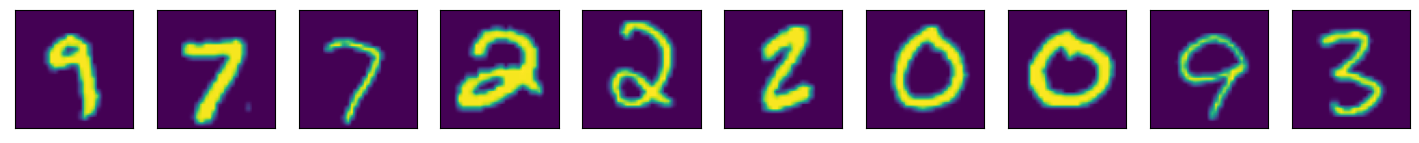

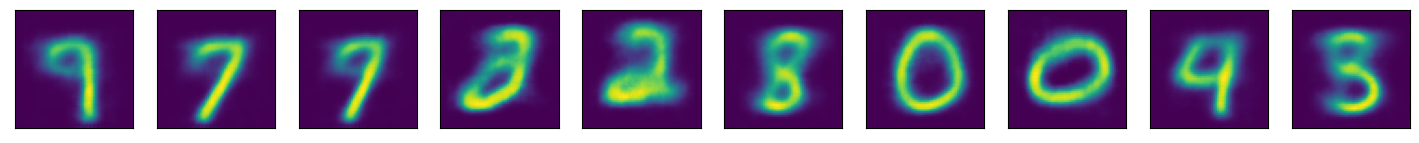

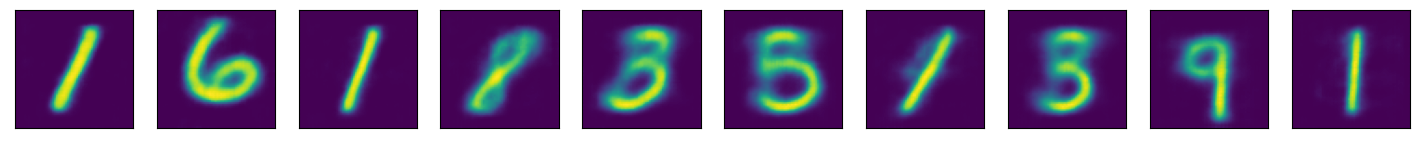

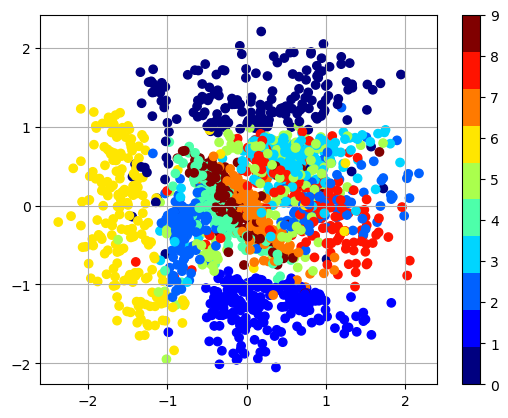

2001
lse_loss 0.011410045623779296
recon_loss 0.13014429956674575
2002
lse_loss 0.018880224227905272
recon_loss 0.1309588834643364
2003
lse_loss 0.02987680435180664
recon_loss 0.1356202945113182
2004
lse_loss -0.0032545089721679687
recon_loss 0.13491968661546708
2005
lse_loss 0.008989763259887696
recon_loss 0.13650694638490676
2006
lse_loss 0.018245172500610352
recon_loss 0.1378718465566635
2007
lse_loss -0.004203128814697266
recon_loss 0.13989046066999436
2008
lse_loss 0.02240786552429199
recon_loss 0.12786792516708373
2009
lse_loss -0.0028439998626708985
recon_loss 0.13516173362731934
2010
lse_loss 0.0070073604583740234
recon_loss 0.13022984713315963
2011
lse_loss 0.004203319549560547
recon_loss 0.13452372699975967
2012
lse_loss 0.005881786346435547
recon_loss 0.12743960842490196
2013
lse_loss 0.00879044532775879
recon_loss 0.13741596192121505
2014
lse_loss 0.013829421997070313
recon_loss 0.14103634804487228
2015
lse_loss 0.007735013961791992
recon_loss 0.13842319697141647
2016
lse_l

2126
lse_loss -0.020137548446655273
recon_loss 0.13230156004428864
2127
lse_loss 0.01005539894104004
recon_loss 0.12889623641967773
2128
lse_loss -0.01237936019897461
recon_loss 0.13056653290987014
2129
lse_loss 0.0020650386810302734
recon_loss 0.1270349234342575
2130
lse_loss -0.0010229110717773437
recon_loss 0.13288016617298126
2131
lse_loss 0.01205291748046875
recon_loss 0.13234052509069444
2132
lse_loss 0.013816642761230468
recon_loss 0.12916825264692305
2133
lse_loss -0.013569021224975586
recon_loss 0.13160378634929656
2134
lse_loss 0.01483922004699707
recon_loss 0.12391290068626404
2135
lse_loss 0.012479209899902343
recon_loss 0.13505569398403167
2136
lse_loss 0.003910589218139649
recon_loss 0.1333063840866089
2137
lse_loss 0.016180038452148438
recon_loss 0.13619394749403
2138
lse_loss 0.0078216552734375
recon_loss 0.13107584416866302
2139
lse_loss 0.00751042366027832
recon_loss 0.12952306717634202
2140
lse_loss -0.0018783092498779296
recon_loss 0.12827755510807037
2141
lse_loss 

2251
lse_loss -0.001958465576171875
recon_loss 0.13401152491569518
2252
lse_loss 0.003343534469604492
recon_loss 0.13518196046352388
2253
lse_loss -0.0026041507720947266
recon_loss 0.13668274879455566
2254
lse_loss 0.023056793212890624
recon_loss 0.1378049671649933
2255
lse_loss -0.009126424789428711
recon_loss 0.1321359932422638
2256
lse_loss 0.004171514511108398
recon_loss 0.1321390837430954
2257
lse_loss -0.011205816268920898
recon_loss 0.13637867271900178
2258
lse_loss 0.011879682540893555
recon_loss 0.13029647171497344
2259
lse_loss 0.0007927417755126953
recon_loss 0.13973996937274932
2260
lse_loss 0.01694169044494629
recon_loss 0.13030502796173096
2261
lse_loss 0.011295938491821289
recon_loss 0.13240177929401398
2262
lse_loss 0.027185916900634766
recon_loss 0.1325448140501976
2263
lse_loss 0.005529451370239258
recon_loss 0.13723697513341904
2264
lse_loss 0.023679208755493165
recon_loss 0.1324160099029541
2265
lse_loss 0.031110095977783202
recon_loss 0.1305303230881691
2266
lse_lo

lse_loss 0.015798139572143554
recon_loss 0.1385320782661438
2377
lse_loss 0.01670236587524414
recon_loss 0.12957511842250824
2378
lse_loss 0.01790165901184082
recon_loss 0.13269447684288024
2379
lse_loss 0.01630086898803711
recon_loss 0.13939105570316315
2380
lse_loss 0.01786036491394043
recon_loss 0.13189524561166763
2381
lse_loss 0.008817052841186524
recon_loss 0.13739332407712937
2382
lse_loss -0.007259225845336914
recon_loss 0.12655876949429512
2383
lse_loss 0.016838741302490235
recon_loss 0.12584779933094978
2384
lse_loss 0.017485618591308594
recon_loss 0.13081039637327194
2385
lse_loss 0.01201333999633789
recon_loss 0.12607145309448242
2386
lse_loss 0.0181365966796875
recon_loss 0.12773221880197524
2387
lse_loss 0.0011163711547851562
recon_loss 0.1298279196023941
2388
lse_loss -0.003956413269042969
recon_loss 0.13944525718688966
2389
lse_loss 0.001900625228881836
recon_loss 0.13952206820249557
2390
lse_loss 0.003836536407470703
recon_loss 0.13770709186792374
2391
lse_loss 0.01403

lse_loss 0.0031723976135253906
recon_loss 0.12324849963188171
2502
lse_loss 0.011597156524658203
recon_loss 0.13218540847301483
2503
lse_loss 0.0004508495330810547
recon_loss 0.12784388437867164
2504
lse_loss 0.011600828170776368
recon_loss 0.12887844890356065
2505
lse_loss -0.0033969879150390625
recon_loss 0.13602505326271058
2506
lse_loss -0.001520061492919922
recon_loss 0.13496020883321763
2507
lse_loss 0.015887117385864256
recon_loss 0.12713877707719803
2508
lse_loss -0.008174419403076172
recon_loss 0.12527290731668472
2509
lse_loss 0.005132627487182617
recon_loss 0.13172266483306885
2510
lse_loss 0.0008099555969238281
recon_loss 0.12955656498670579
2511
lse_loss 0.000655364990234375
recon_loss 0.12931006252765656
2512
lse_loss 0.010746192932128907
recon_loss 0.1291077747941017
2513
lse_loss 0.005434179306030273
recon_loss 0.13331155180931092
2514
lse_loss 0.011607170104980469
recon_loss 0.13117219209671022
2515
lse_loss 0.019453144073486327
recon_loss 0.13026385754346848
2516
lse_

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=hp.M)

            # Backward
            loss = 0
            for key in data.keys():
                if 'kl_loss' in key:
                    loss = loss + data[key] * 0.00025
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=hp.M)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        